In [3]:
# Importing Libraries
import numpy as np 
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
# Create a function that gets all option expirations and loops through to get chains
# Combines each option chain into a dataframe and compute time-to-expiration

def option_chains(ticker): 
    asset = yf.Ticker(ticker) 
    expirations = asset.options
    chains = pd.DataFrame()
    for expiration in expirations:
        opt = asset.option_chain(expiration)
        calls = opt.calls 
        calls["optionType"] = "call"
        puts = opt.puts
        puts["optionType"] = "put"
        chain = pd.concat([calls, puts])
        chain["expiration"] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        chains = pd.concat([chains, chain])
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    return chains

In [5]:
# Download data for e.g. call options on the VOO ETF
options = option_chains("VOO")
calls = options[options["optionType"]=="call"]

# show expirations
set(calls.expiration)

# Choose expiry date to plot
calls_at_expiry = calls[calls["expiration"] == "2023-04-21 23:59:59"]

# Remove low volatilities
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]

In [4]:
# Plot implied volatility term structure
calls_at_strike = options[options["strike"] == 375]

# Remove low volatilities
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]

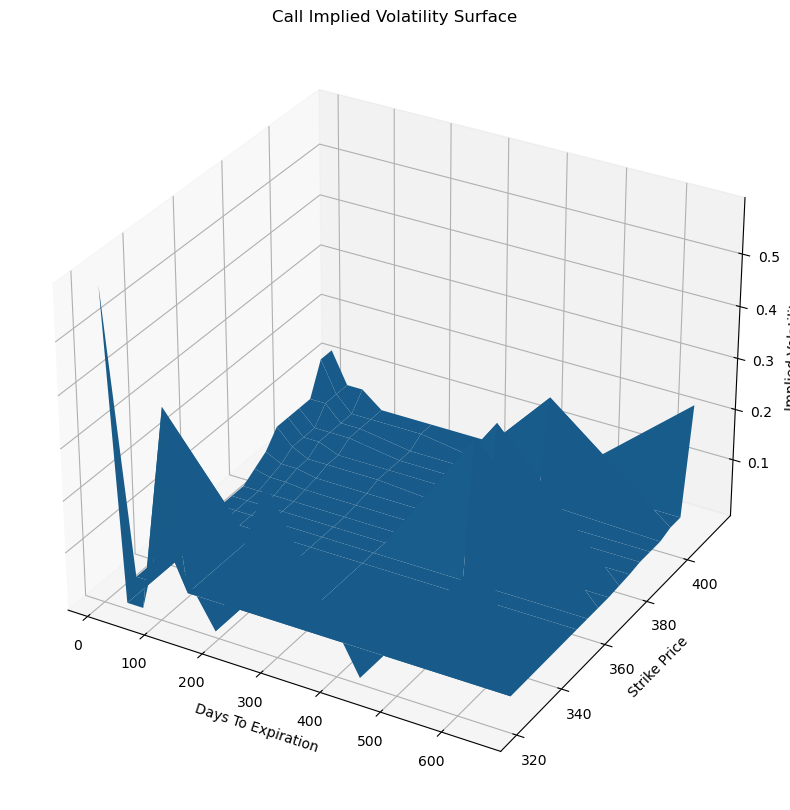

In [26]:
# Plots the implied volatility surface

surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# Create figure object 
fig = plt.figure(figsize=(20, 10))

# Adds subplot with projection
ax = fig.add_subplot(111, projection='3d')

# gets values from dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values
X, Y = np.meshgrid(x, y)

# Sets labels
ax.set_xlabel("Days To Expiration")
ax.set_ylabel("Strike Price")
ax.set_zlabel("Implied Volatility")
ax.set_title("Call Implied Volatility Surface")

ax.plot_surface(X, Y, z)